# Домашнее задание (модуль 10, юнит 4)

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

In [1]:
# Импорт библиотек
# Для загрузки и анализа данных
import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time
import shutil
import random

# Для работы с изображениями и построения моделей
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data.sampler import WeightedRandomSampler
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw, ImageFont
from albumentations import (HorizontalFlip,
                            OneOf,
                            ISONoise,
                            ColorJitter,
                            Equalize,
                            FancyPCA,
                            AdvancedBlur,
                            ImageCompression,
                            RandomToneCurve,
                            RandomGamma,
                            RGBShift,
                            Compose)
import cv2
import shutil
from sklearn.model_selection import train_test_split
from torchmetrics.detection import MeanAveragePrecision

import matplotlib.pyplot as plt

from IPython.display import display

%matplotlib inline

/home/tio/CV/CV_git/homework/m10_HM3/env/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Загрузка и подготовка данных

In [2]:
# Зададим функцию для получения аннотаций из xml файлов. Сами данные уже скачаны, поэтому в функци по умолчанию 
# уже определен путь к локальной папке
def xml_to_csv(path = '/home/tio/CV/CV_git/CV-4. Распознавание объектов. Часть I/VOCdevkit/VOC2012/Annotations',
               img_name='/2010*.xml'):
    """Функция принимает путьк папке содержащей аннотации в формате .xml.
    Задает пустой список для сбора аннотаций из  xml-файлов. В цикле перебирает 
    xml-файлы содержащие в наименовании год 2010. Для каждого файла в цикле 
    перебираются все поля 'object' - объекты записанные в аннотации. Для каждого
    объекта извлеакется имя файла содержащего данный объект, количество каналов,
    ширина и высота изображения, класс объекта и координаты ограничивающей рамки. 
    Извлеченные данные помещаются в кортеж который добавляются в заранее созданный 
    список. После обработки всех файлов список преобразуется в датафрейм, который 
    и возвращает функция. 
    Args:
        path (str, optional): _description_. Defaults to '/home/tio/CV/CV_git/CV-4. \
            Распознавание объектов. Часть I/VOCdevkit/VOC2012/Annotations'.
        img_name (str): имя файла, по умолчанию '/2010*.xml'

    Returns:
        pd.DataFrame: Датафрейм с аннотациями для изображений содержащих в наименовании
        год 2010. 
    """
    # Задаем список для сбора аннотаций
    xml_list = []
    
    # В цмкле перебираем все файлы содержащие год 2010 в наименовании с помощью модуля glob. 
    # glob.glob(pathname) возвращение список путей, соответствующих шаблону pathname.
    for xml_file in tqdm(glob.glob(path + img_name)):
        
        # Считываем файл и получаем его структуру 
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # В цикле перебираем поля 'object'
        for obj in root.findall('object'):
            
            # В каждом находим поле 'bndbox' и извлекаем класс объекта и координаты 
            # ограничивающей рамки
            bbx = obj.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            label = obj.find('name').text
            
            # Формируем кортеж содержащий аннотацию к текущему объекту: имя файла с 
            # изображением, количество каналов, ширина и высота изображения, класс объекта, 
            # координаты ограничивающей рамки 
            value = (root.find('filename').text,
                     int(root.find('size').find('depth').text),
                     int(root.find('size').find('width').text),
                     int(root.find('size').find('height').text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            
            # Добавляем кортеж в список для сбора аннотаций
            xml_list.append(value)
            
    # Задаем список с именами колонок итогового датафрейма с аннотациями
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    
    # Формируем и возвращаем итоговый датафрейм с аннотациями
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [3]:
# Создаем датафрейм с аннотациями, применив нашу функцию.
# Используем все файлы, поэтому задаем шаблон имени '/*.xml'
xml_df = xml_to_csv()#img_name='/*.xml')

# Записываем датафрейм в csv-файл
xml_df.to_csv('VOC_all.csv', index=None)
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:00<00:00, 20716.13it/s]

Конвертация прошла успешно.


In [4]:
# Используем класс LabelEncoder библиотеки sklearn
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [5]:
# Проверяем результат кодировки
xml_df.head()

filename  channels  width  height  class  xmin  ymin  xmax  ymax
0  2010_001344.jpg         3    500     375      7    44    71   491   327
1  2010_006032.jpg         3    500     334      0     1     1   500   334
2  2010_005372.jpg         3    375     500      8    66   311   225   500
3  2010_005372.jpg         3    375     500     19   157   236   242   318
4  2010_006899.jpg         3    500     375     14     2    35   363   375

In [6]:
# Создадим словарь с ключами - порядковыми номерами классов и 
# значениями - метками классов, поменяв местами ключи и значения 
# в ранее созданном словаре.
class_id_to_name_mapping = dict(zip(range(len(le.classes_)), le.classes_))

## Разбиение данных на тренировочную и валидационную выборки

In [7]:
# Посмотрим на распределение преобладающих меток классов объектов на изображениях.
# Получим массив уникальных имен файлов изображений
uniq = xml_df['filename'].unique()

# Сгруппируем данные по имени файла изображения и метке класса объекта на 
# изображении и определим количество и класс объектов для каждого изображения
tab = xml_df.groupby(['filename','class'], as_index=False)['xmin'].count()

# Создадим пустой список для сбора меток классов объектов преобладающих на 
# каждом изображении
major_class = []

# В цикле перебираем каждое наименование файла изображения
for name in uniq:
    
    # Определяем максимальное количество объектов класса для текущего имени файла
    max_obj = tab[tab['filename']==name]['xmin'].max()
    
    # И принимаем для данного изображения этот класс
    # Возможен случай когда на изображении присутствует одинаковое количество объектов 
    # различных классов, поэтому фильтруем нашу таблицу по текущему имени и максмиальному 
    # количеству объектов класса на текущем изображении. Результат преобразуем в список и 
    # добавляем к списку преобладающих классов
    major_class.append(list(tab[(tab['filename']==name) & (tab['xmin']==max_obj)]['class'].values))
    

In [8]:
# Создадим словарь где ключами будут метки классов, а значениями количество 
# изображений на которых этот класс объектов был преобладающим
dict_class = {}

# При заполнении словаря будем учитывать те изображения, где преобладающий класс объектов 
# всего один.В цикле перебираем список преобладающих классов, если длина текущего элемента
# списка преобладающих классов равна единице пробуем увеличить значение словаря по этой метке
# класса (ключу) на единицу. Если записи с таким ключом в словаре еще нет создаем её присвоив 
# значение один
for i in major_class:
    if len(i) == 1:
        try:
            dict_class[i[0]]+=1
        except:
            dict_class[i[0]]=1

# Нам повезло все метки классов попали в словарь, значит для каждого класса в нашем наборе
# данных есть изображение, где он является преобладающим
print(sorted(dict_class.keys()))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [9]:
# Теперь обработаем изображения на которых есть одинаковое количество преобладающих объектов.
# Создадим список для сбора преобладающей на изображении метки класса
ls_class = []

# В цикле перебираем значения списка преобладающих классов major_class (в данном списке значения
# соответствуют списку уникальных имен файлов изображений, т.е. по сути мы перебираем метки классов
# преобладающих на каждом изображении в наборе данных)
for i in major_class:
    
    # Если преобладающий класс на изображении один - вносим его метку в список
    if len(i) == 1:
        ls_class.append(i[0])
        
    # Если таких классов несколько - будем сверяться со словарем преобладающих классов    
    else:
        
        # Создадим вспомагательный список для хранения количества изображений, на которых
        # преобладают интересующие нас классы
        maj_class = []
        
        # В цикле перебираем метки классов равноценно представленных на текущем изображении
        for j in i:
            
            # В вспомогательный список заносим количество изображений для текущей метки 
            # класса из созданного ранее словаря
            maj_class.append(dict_class[j])
            
        # Чтобы уменьшить дисбаланс классов будем для спорных изображений выбирать метку преобладающего 
        # класса с минимальным значением       
        major = i[maj_class.index(min(maj_class))] 
        
        # Вносим метку класса в список и обновляем значения для метки этого класса в словаре
        ls_class.append(major)
        dict_class[major]+=1
            

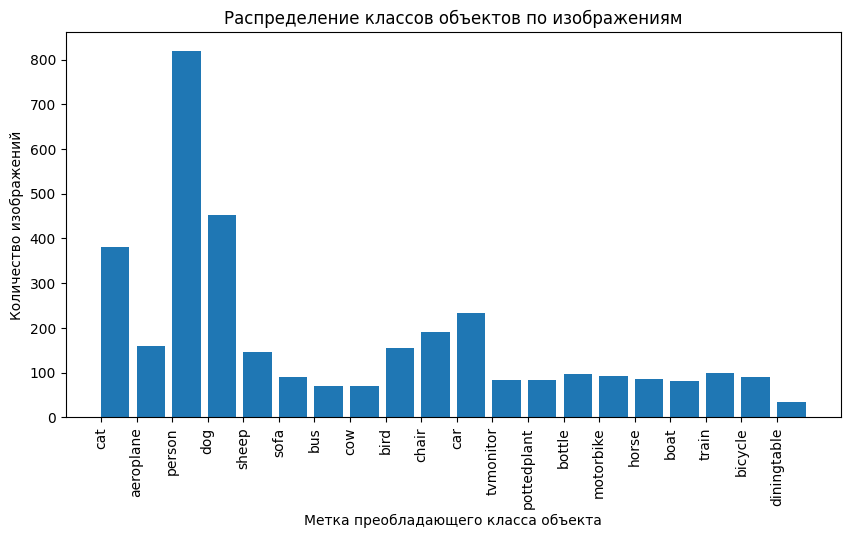

In [10]:
# Визуализируем результат. Определяем значения для оси Х 
x = range(len(dict_class.values()))

# Создаем фигуру
plt.figure(figsize=(10, 5))

# Рисуем столбчатую диаграмму
plt.bar(x, # по оси Х - порядковые номера значений из солваря
       dict_class.values(), # по оси У - значения словаря
       align='edge' # выравнивание столбцов по границе метки, а не по центру
       )

# Задаем метки оси Х. В качестве имен меток используем ключи словаря
plt.xticks(ticks=x,
           labels=[class_id_to_name_mapping[i] for i in dict_class.keys()],
           rotation=90
           )

# Настраиваем наименование графика и осей
plt.xlabel('Метка преобладающего класса объекта')
plt.ylabel('Количество изображений')
plt.title('Распределение классов объектов по изображениям')

# Выводим изображение
%matplotlib inline
plt.show()

# Закрываем окно с графиком, а также освобождаем ресурсы памяти
plt.close()

In [11]:
# Полученный список уникальных наименований файлов изображений и список преобладающих 
# на этих изображениях классов преобразуем в датасет, который будем использовать для 
# стратифицированного разбиения выборки на тренировочный, валидационный и тестовый 
# наборы данных
df = pd.DataFrame({'filename':uniq,
                   'class':ls_class})

# Получаем перечень имен файлов для тренировочной (80%) и валидационной выборки (20%)
# применив стратифицированное разбиение по меткам преобладающего на изображениях класса 
train_name, val_name = train_test_split(df,
                                        shuffle=True,
                                        random_state=42,
                                        train_size=0.8,
                                        stratify=df['class']
                                        )


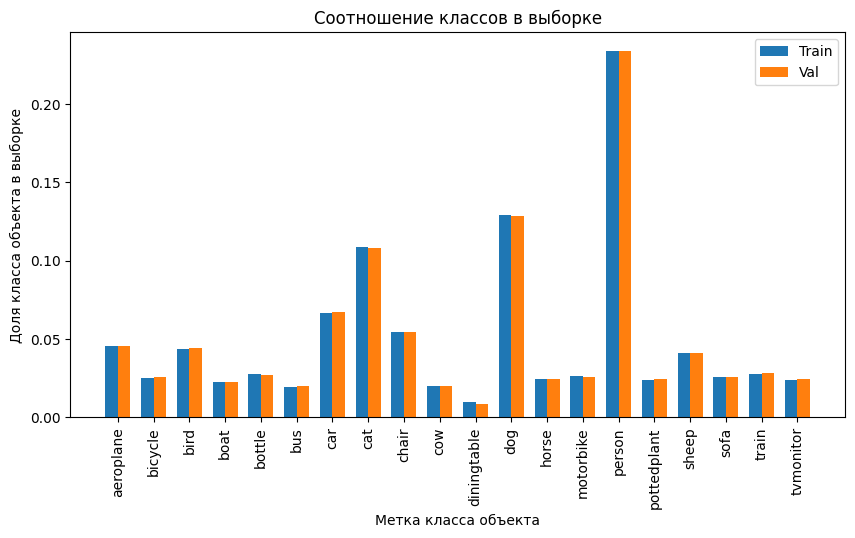

In [12]:
# Подготовим данные для визуализации распределения классов по выборкам. 
# Для этого группируем перечни имен файлов с изображениями по меткам преобладающих 
# на них классов и переименовывам колонку с именами файлов, добавляя префикс 
# соответствующий текущей выборке
df_train = train_name.groupby(['class'], as_index=False).count()
df_train = df_train.rename(columns={'filename':'train_filename','class':'class'})
df_val = val_name.groupby(['class'], as_index=False).count()
df_val = df_val.rename(columns={'filename':'val_filename','class':'class'})

# Объединяем полученные таблицы в вспомогательный датасет по меткам классов
sub_df = pd.merge(df_train, df_val, on='class')

# Вычисляем долю меток классов в каждой выборке
sub_df['train_filename'] = sub_df['train_filename'].apply(lambda x: x/sub_df['train_filename'].sum())
sub_df['val_filename'] = sub_df['val_filename'].apply(lambda x: x/sub_df['val_filename'].sum())

# Визуализируем результат. Задаем вспомагательные переменные - в качестве значений оси Х используем 
# метки классов и ширину столбца столбчатой диаграммы
x = sub_df['class'].values 
width = 0.35

# Создаем фигуру и рисуем столбчатые диаграммы для кадлой выборки. Испоьзуем заданную ранее ширину 
# столбца для смещения столбцов на диаграмме по сои Х
fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, sub_df['train_filename'], width, label='Train')
rects2 = ax.bar(x + width/2, sub_df['val_filename'], width, label='Val')

# Настраиваем отображение
ax.set_ylabel('Доля класса объекта в выборке')
ax.set_xlabel('Метка класса объекта')
ax.set_xticks(ticks=x,
              labels=[class_id_to_name_mapping[i] for i in x],
              rotation=90
              )
ax.legend()
ax.set_title('Соотношение классов в выборке');


In [13]:
# Формируем датафреймы используя сделанное ранее разбиение данных для тренировочной,
# валидационной и тестовой выборок
train_df = xml_df[xml_df['filename'].isin(train_name['filename'].values)]
val_df = xml_df[xml_df['filename'].isin(val_name['filename'].values)]

# Подготовка данных для модели YOLOv5






In [14]:
# Формируем структуру папок, чтобы подготовить набор данных для модели YOLO
for  i in ['train', 'val']:
    im = './y_data/images/' + i
    ann = './y_data/labels/' + i
    try:
        shutil.rmtree(im)
        os.mkdir(im)
    except:
        os.mkdir(im)
    try:
        shutil.rmtree(ann)
        os.mkdir(ann)
    except:
        os.mkdir(ann)

In [15]:
# Переопределим функцию для преобразования аннотаций добавив в качестве 
# аргумента путь для сохранения аннотаций
def convert_to_yolov5(df, unique_img_names, path):
    """Функция принимает датафрейм с аннотациями и перечень уникальных
    имен файлов с изображениями. Для каждого уникального имени находит 
    все аннотации в датафрейме. Преобразует их в формат YOLOv5 (`Class, 
    X, Y, Width, Height`) и нормализует. После нахождения всех объектов
    формирует текстовый файл с аннотациями по пути переданному в аргументе
    path. Процесс повторяется для всех уникальных имен файлов с изображениями
    из полученного перечня.

    Args:
        df (pd.DataFrame): датафрейм с аннотациями в формате ['filename',
        'channels', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax',
        'ymax']
        unique_img_names (numpy.ndarray): массив с уникальными именами файлов
        с изображениями
        path (str): путь к папке для сохранения файла аннотаций.
    """
    
    # преобразуем полученный датафрейм в массив списков 
    # для перебора в цикле 
    df_array = np.array(df)
    
    # Для каждого уникального изображения
    for unique_img_name in unique_img_names:
        
        # Создаем переменную буфер
        print_buffer = []

        # Перебираем в цикле индексы всех объектов из полученного датафрейма
        for i in range(len(df)):            
        
            # получаем текущий элемент массива
            point =  df_array[i]
        
            # извлекаем имя файла аннотации - первая колонка датафрейма
            img_name = point[0]

            # если имя файла аннотации соответствует текущему уникальному 
            # имени изображения
            if img_name == unique_img_name:
                
                # записываем метку класса объекта - пятая колонка датафрейма
                class_id = point[4]
      
                # Преобразуем координаты bbox. Здесь point[5] - xmin, point[6] - ymin, 
                # point[7] - xmax, point[8] - ymax. Вычисляем координаты центра ограничительной 
                # рамки
                X = (point[5] + point[7]) / 2 
                Y = (point[6] + point[8]) / 2 
                
                # Вычисляем ширину и высоту ограничительной рамки
                Width = (point[7] - point[5])
                Height = (point[8] - point[6])
              
                # Нормализуем координаты, разделив полученные значения на ширину и длину изображения
                image_c, image_w, image_h = point[1], point[2], point[3] 
                X /= image_w 
                Y /= image_h 
                Width /= image_w 
                Height /= image_h 
              
                # Запишем информацию о bbox в файл
                print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))  
                
        # Дадим имя файлам, которые хотим сохранить. В качестве пути сохранения 
        # используем переданный в аргументах путь
        save_file_name = os.path.join(path, unique_img_name.replace("jpg", "txt"))
        
        # Объединяем элементы списка в строку используя в качестве разделителя символ 
        # переноса коретки "\n" и сохраняем результат вывода аннотации в файл на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [16]:
# Получим аннотации в новом формате для каждой выборки
convert_to_yolov5(df=train_df,
                  unique_img_names=train_df['filename'].unique(),
                  path='./y_data/labels/train'
                  )
convert_to_yolov5(df=val_df,
                  unique_img_names=val_df['filename'].unique(),
                  path='./y_data/labels/val'
                  )

In [17]:
# Задаем путь к исходной папке, где хранятся все изображения
path_s = r'/home/tio/CV/CV_git/CV-4. Распознавание объектов. Часть I/VOCdevkit/VOC2012/JPEGImages/'

# Задаем путь к целевой папке, где будут хранится изображения каждой выборки
path_d = r'y_data/images/'

# В цикле перебираем наименование всех изображений в выборке и копируем 
# файл изображения в соответствующую целевую папку
for file in train_df['filename'].unique():
    shutil.copyfile(path_s+file, path_d+'train/'+file)
    
for file in val_df['filename'].unique():
    shutil.copyfile(path_s+file, path_d+'val/'+file)

In [18]:
# Проверяем что все изображения имеют аннотации
counter_t = []
for name in os.listdir('y_data/images/train/'):
    if name.replace('jpg', 'txt') not in os.listdir('y_data/labels/train/'):
        counter_t.append(name)
print(f'Количество изображений без аннотаций в обучающей выборке: {len(counter_t)}')
    
counter_v = []
for name in os.listdir('y_data/images/val/'):
    if name.replace('jpg', 'txt') not in os.listdir('y_data/labels/val/'):
        counter_v.append(name)
print(f'Количество изображений без аннотаций в валидационной выборке: {len(counter_v)}')        

Количество изображений без аннотаций в обучающей выборке: 0
Количество изображений без аннотаций в валидационной выборке: 0


In [19]:
# Выполняем проверку на дублирование изображений в папках train и val
ls=[]
for name in os.listdir('y_data/images/train/'):
    if name in os.listdir('y_data/images/val/'):
        ls.append(name)

print(f'Количество изображений пристуствующих в обеих выборках: {len(ls)}')

Количество изображений пристуствующих в обеих выборках: 0


# Подготовка данных для модели FRCNN





In [20]:
# Определим вспомогательную функцию для получения списка аугментаций изображений
def get_transforms(phase):
    """Функция принимает на вход строку с текущим флагом выборки.
    Если флаг соответствует 'train', функция возвращает пайплайн 
    аугментаций изображения для тренировочной выборки. Если нет 
    в пайплайн включается только преобразование изображения в тензор
    Args:
        phase (str): флаг выборки

    Returns:
        Compose: пайплайн аугментаций изображения
    """
    # Задаем пустой список для сбора аугментаций    
    list_transforms = []
    
    # Проверяем передан ли флаг тренировочной выборки
    if phase == 'train':
        
        # Для тренировочной выборки определяем аугментации поворота изображения,
        # добавления шумов, изменнеие цветов, гаммы ит.п.
        list_transforms.extend([HorizontalFlip(p=1),
                                OneOf([ISONoise(),
                                       ColorJitter(hue=0.1),
                                       Equalize(by_channels=False),
                                       FancyPCA(),
                                       AdvancedBlur(p=0.1),
                                       ImageCompression(),
                                       RandomToneCurve(),
                                       RandomGamma(),                                          
                                       RGBShift(r_shift_limit=0.1,
                                                g_shift_limit=0.1,
                                                b_shift_limit=0.1
                                                )
                                       ]
                                      )
                                ]
                               )

    # Добавляем преобразование изображения в тензор            
    list_transforms.extend([ToTensorV2()])

    # Создаем пайплайн аугментаций            
    list_trfms = Compose(list_transforms,
                         bbox_params={'format': 'pascal_voc', # формат ограничивающих рамок
                                      'label_fields': ['labels']  # список полей, которые соединены с ограничительными рамками
                                      }                         
                         )
    
    # Возвращаем полученный пайплайн аугментаций
    return list_trfms

In [21]:
# Создаем кастомный класс для формирования датасета
class VOC_2010(Dataset):
      
    # Функция инициализации
    def __init__(self, df, image_dir, phase='train'):
        
        # Вызываем метод инициализации из родительского класса
        super().__init__()
        
        # Дополняем наши данные
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)
        
    # Задаем функцию для определения количества изображений 
    # в датасете
    def __len__(self):
        return len(self.images)
    
    # Определяем функцию для получения экземпляра из датасета по индексу
    def __getitem__(self,idx):
        
        # Получаем имя файла изображения
        image = self.images[idx]

        # Отбрасываем расширение файла
        image_id = str(image.split('.')[0])
        
        # Считываем файл изображения
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        
        # Преобразуем порядок каналов в RGB        
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0
        
        # Получаем строку датасета для текущего изображения
        point = self.df[self.df['filename'] == image]
        
        # Записываем в переменную координаты ограничительной рамки
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # Вычисляем площадь внутри ограничительной рамки
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)
        
        # Формируем словарь с аннотациями
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        
        # Применяем аугментации
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                # Здесь пришлось добавить преобразование тензора в список, потому 
                # что при итерации по тензору он возвращает тензор с одним числом, 
                # но получить метку класса используя тензор в качестве ключа не получится
                'labels': target['labels'].tolist()
            }
            sample = self.transforms(**sample)
            image = sample['image']
        
        # Переопределяем координаты ограничительных рамок после аугментации изображений 
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        # Возвращаем кортеж из изображения, словаря с аннотациями и имени файла 
        return image, target, image_id
            

In [22]:
# Копируем выборки
frcnn_train_df = train_df.copy()
frcnn_val_df = val_df.copy()

# Получаем словарь весов преобладающих классов как обратную величину вероятности
# преобладающего класса 
im_weight = df['class'].value_counts(normalize=True)
im_weight = im_weight.apply(lambda x: 1 - x).to_dict()

# Создаем признак веса изображения по преобладающему классу
df['img_weight'] = df['class'].apply(lambda x: im_weight[x])

# Получаем словарь весов изображений по преобладающему классу
img_weight = dict(zip(df['filename'], df['img_weight']))

# Добавляем веса изображений в наши выборки
frcnn_train_df['img_weight'] = frcnn_train_df['filename'].apply(lambda x: img_weight[x])
frcnn_val_df['img_weight'] = frcnn_val_df['filename'].apply(lambda x: img_weight[x])

В [документации](https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html) указано, что метка 0 зарезервирована для фонового класса:
 - labels, integer torch.Tensor of shape [N]: the label for each bounding box. 0 represents always the background class.

In [23]:
# Переопределим метки классов
labels_dict = dict(zip(range(1, len(le.classes_) + 1), le.classes_))

frcnn_train_df['class'] = train_df['class']+1
frcnn_val_df['class'] = val_df['class']+1

In [24]:
# Определяем путь к директории с изображениями
image_dir = '../../CV-4. Распознавание объектов. Часть I/VOCdevkit/VOC2012/JPEGImages'

# Формируем тренировочный и валидационный датасеты с помощью определенного выше класса
train_data = VOC_2010(frcnn_train_df, image_dir, phase='train')
val_data = VOC_2010(frcnn_val_df, image_dir, phase='validation')

# Проверяем размер полученных датасетов
print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(val_data)}')

Размер обучающей выборки 2802
Размер валидационной выборки 701


/home/tio/CV/CV_git/homework/m10_HM3/env/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [25]:
# Определяем размер батча и функцию, определяющую порядок формирования батча
batch = 4
def collate_fn(batch):
    return tuple(zip(*batch))

# Получаем тензоры с весами изображений
img_weight_train = torch.as_tensor(np.array(frcnn_train_df.drop_duplicates(subset='filename')['img_weight']),
                                   dtype=torch.float16
                                   )
img_weight_val = torch.as_tensor(np.array(frcnn_val_df.drop_duplicates(subset='filename')['img_weight']),
                                   dtype=torch.float16
                                   )

# Создаем объект sampler для борьбы с дисбалансом классов
train_sampler = WeightedRandomSampler(img_weight_train, len(img_weight_train))
val_sampler = WeightedRandomSampler(img_weight_val, len(img_weight_val))

# Формируем объекты класса DataLoader для полученных датасетов
train_data_loader = DataLoader(train_data,
                              batch_size=batch,
                              shuffle=False,
                              sampler=train_sampler,
                              collate_fn=collate_fn
                              )
val_data_loader = DataLoader(val_data,
                             batch_size=batch,
                             shuffle=False,
                             sampler=val_sampler,
                             collate_fn=collate_fn
                             )

In [26]:
# Определим функцию для визуализации батча изображений
def vis_batch(dataloader):
    
    # Определяем количество батчей в даталоадере
    batch_count = dataloader.__len__()
    
    # Случайным образом выбираем номер батча
    ind = random.choice(range(batch_count))
  
    # Создаем итератор на основе полученного даталоадера
    batch_iter = iter(dataloader)

    # Перебираем итератор в цикле    
    for idx, (images, target, names)  in enumerate(batch_iter):
        
        # Когда номер батча совпадает с выбранным
        if idx == ind:
            
            # Выводим номер батча
            print("Номер батча: ", ind)
            
            # Определяем полотно соответствующее количеству изображений в батче    
            fig, axes = plt.subplots(1, len(images), figsize=(16, 8))
            
            # Задаем цикл соответствующей количеству изображений в батче
            for j, image in enumerate(images):
                
                # подготавливаем изображение
                image = image.clone().cpu().numpy()
                image = image.transpose((1,2,0))
                image = (image * 255).astype(np.uint8)                
                image = np.ascontiguousarray(image)
                
                # получаем координаты для всех ограничительных рамок текущего изображения
                bbox = target[j]['boxes'].numpy()
                
                # В цикле перебираем каждую ограничительную рамку и отображаем ее на изображении
                for i, box in enumerate(bbox):
                    cv2.rectangle(image,
                                  (int(box[0]),int(box[1])),
                                  (int(box[2]),int(box[3])),
                                  (255,0,0),
                                  thickness=3
                                  )
                    
                    # Выводим класс объекта
                    cv2.putText(image,
                                f'{labels_dict[target[j]["labels"][i].item()]}',
                                (int(box[0]),int(box[1])+30), # расположение
                                cv2.FONT_HERSHEY_SIMPLEX, # шрифт
                                1.5, # размер шрифта
                                (255,0,0), # цвет
                                3 # толщина
                                )
               
                # Выводим изображение                
                axes[j].imshow(image)
                 
                # отключаем отображение осей
                axes[j].axis("off")
                

Номер батча:  25


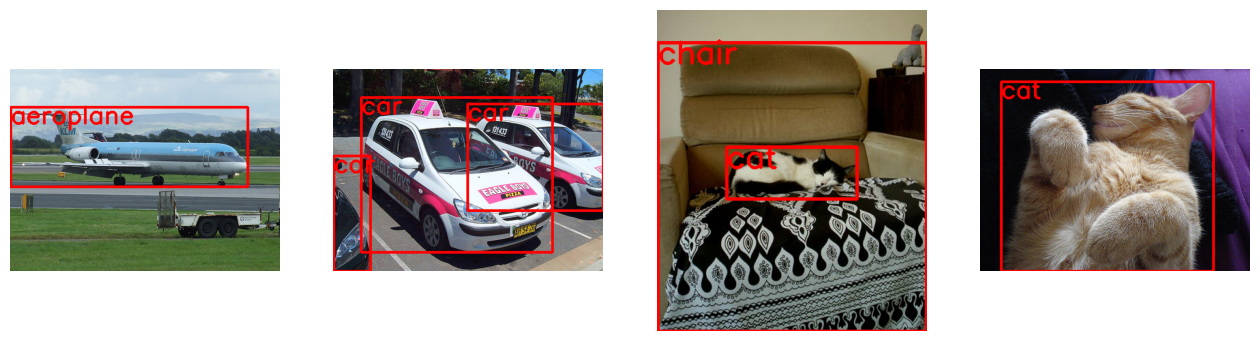

In [27]:
# Визуализируем случайный батч из валидационной выборки
vis_batch(val_data_loader)

In [28]:
ostanovka

NameError: name 'ostanovka' is not defined

# Обучение

# YOLOv5

In [ ]:
# Клонируем репозитарий yolov5 
!git clone https://github.com/ultralytics/yolov5

# Устанавливаем необходимые зависимости
!pip install -r yolov5/requirements.txt

Клонирование в «yolov5»...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Получение объектов: 100% (17516/17516), 16.62 МиБ | 9.09 МиБ/с, готово.
Определение изменений: 100% (12001/12001), готово.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3.8 -m pip install --upgrade pip


Создадим файл y_data.yaml, содержащий пути к нашим данным и расшифровку меток классов, следующего содержания:

```
# Dataset root directory relative to the yolov5 directory
path: /home/tio/CV/CV_git/homework/m10_HM3/y_data/

# Train/val/test sets: specify directories, *.txt files, or lists
train: images/train # images for training
val: images/train # images for validation

# Classes
names:
    0: 'aeroplane'
    1: 'bicycle'
    2: 'bird'
    3: 'boat'
    4: 'bottle'
    5: 'bus'
    6: 'car'
    7: 'cat'
    8: 'chair'
    9: 'cow'
    10: 'diningtable'
    11: 'dog'
    12: 'horse'
    13: 'motorbike'
    14: 'person'
    15: 'pottedplant'
    16: 'sheep'
    17: 'sofa'
    18: 'train'
    19: 'tvmonitor'
```

In [ ]:
# Для обучения используем скрипт train.py из скачанного репозитория. Задаем размер изображений, 
# размер батча (для автоматического определения можно указать -1), указываем путь к файлу data.yaml
# и указываем предварительно обученные веса для модели yolov5m.
# Фиксируем время начала и окончания обучения
start = time()
!python yolov5/train.py --batch -1 --weights yolov5m.pt --data y_data.yaml --epochs 50 --cache --img 640
stop = time() 

train: weights=yolov5m.pt, cfg=, data=y_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1

In [ ]:
# Результаты обучения сохраняются в папке "./yolov5/runs/train/exp" с 
# соответствующим номером эксперимента. Лучший результат записывается в 
# папку weights под именем best.pt. В папке Задаем путь к локальной папке 
# с копией репозитария yolov5 и к нашей обученной модели
yolo_path = './yolov5'
model_name="./yolov5/runs/train/exp/weights/best.pt"

# Загружаем модель из локальной директории
model = torch.hub.load(repo_or_dir=yolo_path,
                       model='custom',
                       source='local',
                       path = model_name
                       )

YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)

Fusing layers... 
Model summary: 212 layers, 20929713 parameters, 0 gradients, 48.1 GFLOPs
Adding AutoShape... 


/home/tio/CV/CV_git/homework/m10_HM3/./yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 332x500 1 cat
Speed: 6.9ms pre-process, 43.4ms inference, 97.7ms NMS per image at shape (1, 3, 448, 640)


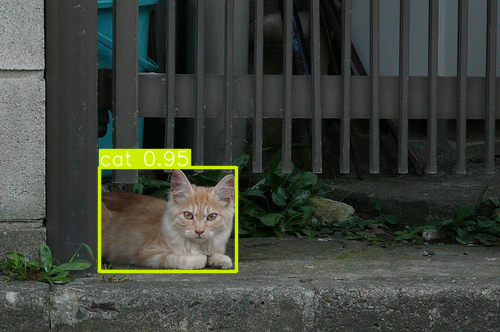

[tensor([[0.33569, 0.66092, 0.27292, 0.31123, 0.94738, 7.00000]], device='cuda:0')]


In [ ]:
# Выберем изображение для визуализации
img_name = os.listdir("./y_data/images/val/")[42]

# Зададим путь к изображению из валидационной выборки
img_path = './y_data/images/val/' + img_name

# Получим прогноз модели для изображения из тестовой выборки. 
# Можно передать список из нескольких изображений, но для наглядности ограничимся одним
results = model([img_path])

# Выводим результат прогноза
results.print()

# Визуализируем изображение с прогнозом нашей модели
results.show()

# Можно отобразить координаты ограничивающих рамок, вероятность и метку предсказанного
# класса объекта. Например, в формате xywhn 
print(results.xywhn)

In [ ]:
# Определим функцию для визуализации изображения с аннотациями - ограничительные
# рамки и метки классов
def plot_bounding_box(image, annotation_list):
    """Функция принимает на вход файл с изображением и список с аннотациями к 
    этому изображению в формате YOLOv5 (`Class, X, Y, Width, Height`). Возвращает 
    координаты рамок и их размеры к масштабу изображения. Вычисляет минимальные и 
    максимальные значения координат ограничительных рамок (верхний левый и нижний 
    правый углы). Формирует и выводи изображение с отрисованными ограничительными 
    рамками и метками классов.

    Args:
        image (PIL.JpegImagePlugin.JpegImageFile): загруженное изображение
        annotation_list (list): список аннотаций к загруженному изображению
    """
    # Преобразуем список со списками аннотаций в numpy массив
    annotations = np.array(annotation_list)
    
    # Получаем размеры изображения
    w, h = image.size
    
    # Создаем объект Draw из нашего изображения для отображения на нем 
    # ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
    plotted_image = ImageDraw.Draw(image)
    
    # Создаем копию массива аннотаций
    transformed_annotations = np.copy(annotations)
    
    # Возвращаем координаты центра, ширину и длину ограничительных рамок к обычному
    # формату (в масштаб изображения)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    # Преобразуем координаты ограничительных рамок в формат x0, y0, x1, y1 - минимальные и 
    # максимальные значения координат (верхний левый и нижний правый углы)
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    # В цикле перебираем все аннотации
    for ann in transformed_annotations:
        
        # Получаем параметры текущей аннотации
        obj_cls, x0, y0, x1, y1 = ann
        
        # Отрисовываем на объекте Draw ограничительную рамку
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        # Добавляем метку класса
        plotted_image.text((x0, y0), # координаты метки 
                           class_id_to_name_mapping[(int(obj_cls))], # метка класса
                           fill="red", # цвет текста
                           font=ImageFont.load_default(size=16) # размер шрифта                     
                           )
    
    # Преобразовываем массив в изображение и выводим его на экран
    plt.imshow(np.array(image))
    plt.show()  
    
    # Закрываем окно с графиком, а также освобождаем ресурсы памяти
    plt.close()
    

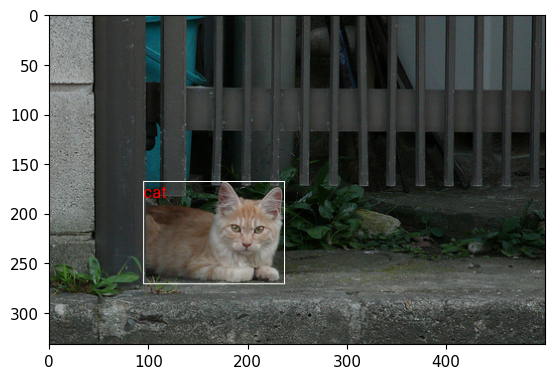

In [ ]:
%matplotlib inline
# Визуализируем исходное изображения с аннотациями.
# Зададим путь к изображению из валидационной выборки
img_path = './y_data/images/val/' + img_name

# Визуализируем ограничительные рамки из файла аннотации.
# Задаем путь к файлу с аннотацией для нашего изображения
annotation_file = './y_data/labels/val/' + img_name.replace('.jpg', '.txt')
    
# Открываем файл с аннотациями
with open(annotation_file, "r") as file:
    
    # Считываем аннотации и преобразуем полученную строку в список аннотаций, 
    # разбивая по символу переноса каретки. Последний элемент списка будет 
    # пустым, поэтому отбрасываем его
    annotation_list = file.read().split("\n")[:-1]
    
    # Каждая аннотация теперь представлена в виде строки. Преобразуем их в 
    # списки разбив строку по символу пробела
    annotation_list = [x.split(" ") for x in annotation_list]
    
    # Каждый элемент аннотации преобразуем в число типа float
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# Используем определенную ранее функцию для визуализации изображения 
# с ограничительными рамками
plot_bounding_box(image=Image.open(img_path),
                  annotation_list=annotation_list
                  )


In [ ]:
# Сформируем словарь с результатами
result_dict = {'model': ['YOLO v5m'],
               'parameters': [20929713],
               'GFLOPs': [48.1],
               'train_time, s': [stop - start],
               'time_per_epoch, s': [round((stop - start)/50)],
               'mAP_50': [0.71],
               'mAP_50_95': [0.511]
               }

# Преобразуем его в датафрейм и отобразим результат
df = pd.DataFrame(data=result_dict)
display(df)

# Запишем результат в файл
df.to_csv('results_df.csv', index=False, header=True)


model  parameters  GFLOPs  train_time, s  time_per_epoch, s  mAP_50  \
0  YOLO v5m    20929713    48.1    2129.473702                 43    0.71   

   mAP_50_95  
0      0.511

# FRCNN

## Загрузка модели

In [ ]:
# По возможности переключаемся на видеокарту
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [ ]:
# Загружаем модель с предобученными весами
model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')

# Получаем число классов и увеличиваем его на 1 так как 0 - это класс фона
num_classes = frcnn_train_df['class'].nunique() + 1 

# Получим число входных признаков для классификатора
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features

# Заменим классификатор на новый
model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Определяем функцию для обучения в течение одной эпохи
def epoch_train(model, mode, dataloader, optimizer):
    """Функция для выполнения обучения на одной эпохе

    Args:
        model (models.common.AutoShape): модель
        mode (str): наименование режима ('train' для обучения)
        dataloader (torch.utils.data.dataloader.DataLoader): даталоадер
        optimizer (torch.optim): оптимизатор
    Returns:
        numpy.float64: среднее значение суммарной ошибки за эпоху
    """
    
    # Включаем подсчет градиентов если текущий режим train
    if mode == 'train':        
        torch.set_grad_enabled(True)
    # Иначе - отключаем
    else:        
        torch.set_grad_enabled(False)
    
    # Задаем пустой список для сбора ошибок модели на батче  
    epoch_loss = []
    
    # В цикле проходим по всем батчам в даталоадере   
    for images, targets, _ in dataloader:
        
        # Переносим изображение и аннотацию на используемое устройство
        images = [image.to(device) for image in images]
        targets = [{key: val.to(device) for key, val in t.items()} for t in targets]
                
        # Выполняем прямой проход
        loss_dict = model(images, targets)
        
           
        # Заносим в переменную суммарную ошибку на текущем батче
        batch_loss = sum(loss_val for loss_val in loss_dict.values())
        
        # Преобразуем значение оштбки в число методом .item() и записываем значение в список потерь
        epoch_loss.append(batch_loss.item())   
        
        # Если текущий режим 'train', выполняем обратный проход
        if mode == 'train':
            with torch.no_grad():                        
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                
    # Возвращаем среднее значение суммарной ошибки за эпоху
    return np.mean(epoch_loss)

      
# Определим функцию для обучения модели
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    """Функция для обучения модели. Модель с наименьшей суммарной ошибкой за эпоху 
    на валидационной выборке сохраняется в корневой папке.

    Args:
        model (models.common.AutoShape): модель
        train_dataloader (torch.utils.data.dataloader.DataLoader): обучающий даталоадер
        val_dataloader (torch.utils.data.dataloader.DataLoader): валидационный даталоадер
        optimizer (torch.optim): оптимизатор
        num_epochs (int): количество эпох обучения

    Returns:
        tuple: кортеж из списков средних значений суммарных ошибок модели на эпохах для 
        тренировочной и валидационной выборок
    """
    # Задаем списки для сбора ошибок модели и времени работы на эпохах
    train_loss = []
    val_loss = []
    epoch_time = []
        
    # Переводим модель в режим обучения
    model.train()
    
    # Задаем начальное порговое значение ошибки
    min_loss = 10e6
    
    # В цикле передвигаемся по количеству эпох
    for epoch in tqdm(range(num_epochs)):
        
        # Запоминаем время начала эпохи
        start_time = time()
        
        # На каждой эпохе вызываем определенную выше функцию в режиме обучения и в режиме валидации, 
        # занося полученнле значение ошибки в соответствующий список
        loss = epoch_train(model=model, mode='train', dataloader=train_dataloader, optimizer=optimizer)
        train_loss.append(loss)
        loss = epoch_train(model=model, mode='val', dataloader=val_dataloader, optimizer=optimizer)
        val_loss.append(loss)
        
        # Проверяем, что среднее значение суммарной ошибки за эпоху на валидационной выборке ниже
        # порогового значения
        if loss < min_loss:
            
            # если это так, обновляем пороговое значение
            min_loss = loss
            
            # и сохраняем модель как лучший результат
            torch.save(model, 'FRCNN_best.pth')
            
            # выводим сообщение о сохранении
            print('Epoch ', epoch, ' save model: done')
        
        # Фиксируем время окончания эпохи и заносим в список длительность текущей эпохи
        stop_time = time()    
        epoch_time.append(stop_time - start_time)

    # Включаем подсчет градиентов                       
    torch.set_grad_enabled(True)
    
    # Возвращаем кортеж из списков средних значений суммарных ошибок модели на эпохах 
    # для тренировочной и валидационной выборок   
    return train_loss, val_loss, epoch_time



In [ ]:
# Переносим модель на используемое устройство
model_rcnn.to(device)

# Задаем параметры оптимизатора
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)

In [ ]:
# Запускаем обучение модели
train_loss, val_loss, epoch_time = train_model(model=model_rcnn,
                                               optimizer=optimizer,
                                               train_dataloader=train_data_loader,
                                               val_dataloader=val_data_loader,
                                               num_epochs=50
                                               )

  2%|▏         | 1/50 [07:01<5:44:17, 421.59s/it]

Epoch  0  save model: done


  4%|▍         | 2/50 [14:00<5:36:00, 420.00s/it]

Epoch  1  save model: done


  6%|▌         | 3/50 [20:55<5:27:20, 417.89s/it]

Epoch  2  save model: done


  8%|▊         | 4/50 [27:53<5:20:12, 417.66s/it]

Epoch  3  save model: done


 10%|█         | 5/50 [34:33<5:08:40, 411.56s/it]

Epoch  4  save model: done


 14%|█▍        | 7/50 [48:03<4:52:07, 407.62s/it]

Epoch  6  save model: done


100%|██████████| 50/50 [5:38:17<00:00, 405.95s/it]  


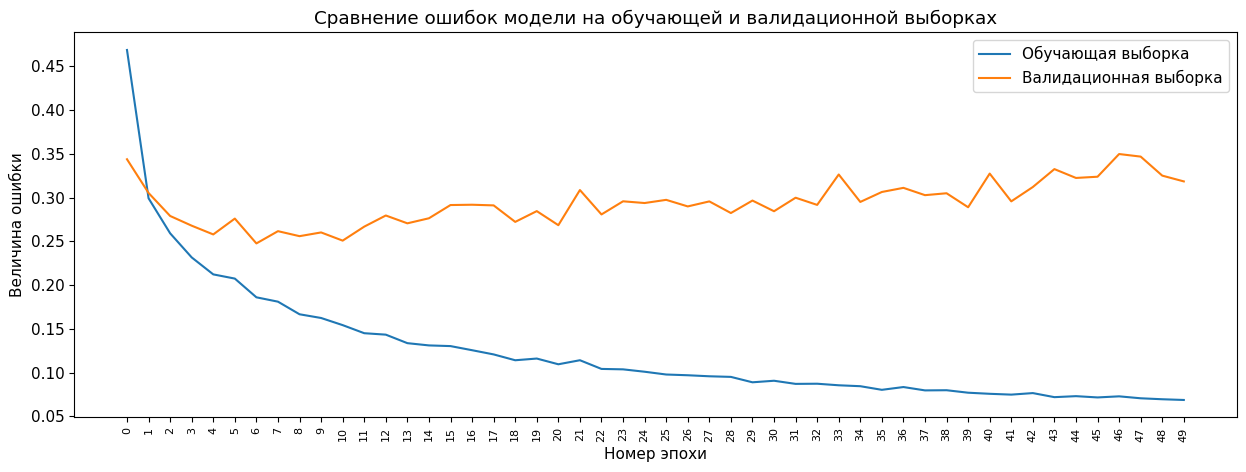

In [ ]:
# Визуализиреум ошибки модели на обучающей и валидационной выборках
# Создаем фигуру
plt.figure(figsize=(15, 5))

# Определяем количество эпох для отображения по оси Х
x = range(len(train_loss))

# Строим графики ошибок модели на обучающей и валидационной выбороках
plt.plot(x, train_loss, label='Обучающая выборка')
plt.plot(x, val_loss, label='Валидационная выборка')

# Настраиваем отображение
plt.title('Сравнение ошибок модели на обучающей и валидационной выборках')
plt.legend()
plt.xticks(ticks=x, fontsize=8, rotation=90)
plt.xlabel('Номер эпохи')
plt.ylabel('Величина ошибки')
plt.show()

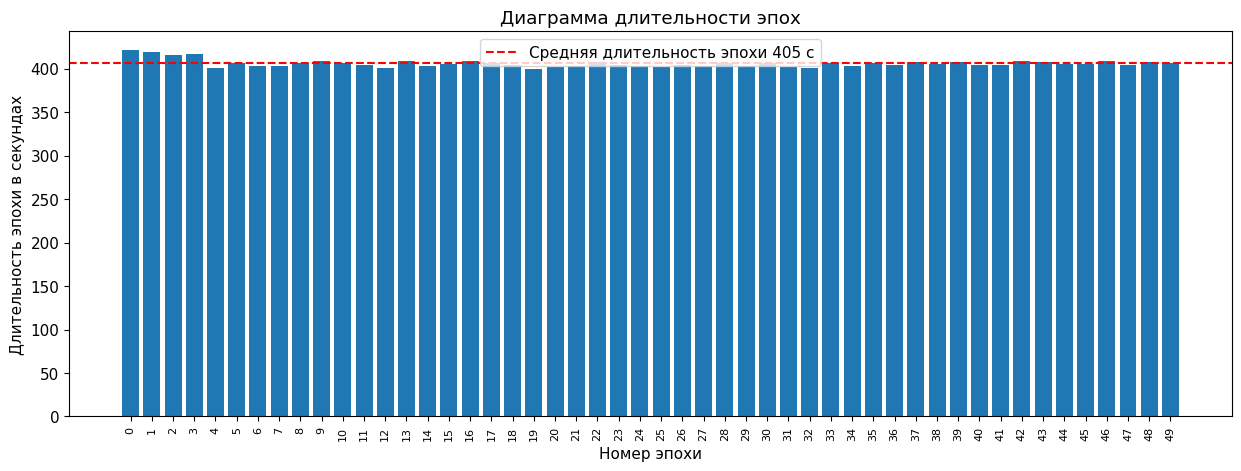

In [ ]:
# Визуализиреум длительность эпох
# Создаем фигуру
plt.figure(figsize=(15, 5))

# Определяем количество эпох для отображения по оси Х
x = range(len(epoch_time))

# Строим столбчатую диаграмму длительности эпох
plt.bar(x, epoch_time, align='center')

plt.axhline(y=np.mean(epoch_time), color='red', linestyle='--', label=f'Средняя длительность эпохи {int(np.mean(epoch_time))} с')

# Настраиваем отображение
plt.legend()
plt.title('Диаграмма длительности эпох')
plt.xticks(ticks=x, fontsize=8, rotation=90)
plt.xlabel('Номер эпохи')
plt.ylabel('Длительность эпохи в секундах')
plt.show()

In [ ]:
# Загружаем лучшую модель сохраненную при обучении
f_rcnn_model = torch.load('FRCNN_best.pth')

# Переносим модель на используемое устройство
f_rcnn_model.to(device)

# Задаем пустые списки для сбора результатов прогноза и истинных ответов
f_rcnn_target_ls = []
f_rcnn_preds=[]
ind_img =[]

# В цикле получаем батчи изображений и аннотации к ним
for images, targets, image_ids in tqdm(val_data_loader):
    
    ind_img.extend([i for i in image_ids])
    
    # переносим тензоры изображений и аннотаций на устройство (CUDA/cpu)
    img = [i.to(device) for i in images] 
    target = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Сохраняем аннотации в список
    f_rcnn_target_ls.extend(target)
    
    # Переводим модель в режим оценки и отключаем подсчет градиентов
    f_rcnn_model.eval()
    with torch.no_grad():
        result = f_rcnn_model(img)
    
    # Сохраняем прогноз модели в список    
    f_rcnn_preds.extend(result)

100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


In [ ]:
# Создадим новый список для сбора прогнозов модели с заданым порогом уверенности
f_rcnn_preds_filtred = []

# В цикле переберем полученные для изображений прогнозы
for pred in f_rcnn_preds:
    
    # Созлаем пустые списки для сбора результатов
    box=[]
    label=[]
    score=[]

    # Преобразуем тензоры в numpy массивы
    ar_box = pred['boxes'].cpu().numpy()
    ar_label = pred['labels'].cpu().numpy()
    ar_score = pred['scores'].cpu().numpy()

    # В цикле проходим по всем прогнозам модели для текущего изображения
    for i in range(len(pred['scores'])):
        
        # Если увереность модели больше порогового значения
        if ar_score[i]>=0.25:
            
            # Заносим прогноз в списки
            box.append(ar_box[i])
            label.append(ar_label[i])
            score.append(ar_score[i])
    
    # Отсортированный прогноз преобразуем в словарь с тензорами
    result = {'boxes':torch.from_numpy(np.array(box)).cuda(),
              'labels':torch.from_numpy(np.array(label)).cuda(),
              'scores':torch.from_numpy(np.array(score)).cuda()
              }
    
    # Добавляем прогноз в новый список
    f_rcnn_preds_filtred.append(result)
        

In [ ]:
# Создаем объект класса MeanAveragePrecision из модуля torchmetrics.detection 
metric_rcnn = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

# Передаем полученные списки в объект класса MeanAveragePrecision
metric_rcnn.update(f_rcnn_preds_filtred, f_rcnn_target_ls)

# Расчитываем метрику для тестовой выборки
result_iou = metric_rcnn.compute()

# Выводим результат
display(result_iou)

{'map': tensor(0.45182),
 'map_50': tensor(0.73642),
 'map_75': tensor(0.49757),
 'map_small': tensor(0.30234),
 'map_medium': tensor(0.36788),
 'map_large': tensor(0.50427),
 'mar_1': tensor(0.41532),
 'mar_10': tensor(0.57491),
 'mar_100': tensor(0.57491),
 'mar_small': tensor(0.34783),
 'mar_medium': tensor(0.47449),
 'mar_large': tensor(0.61612),
 'map_per_class': tensor([0.63742, 0.57751, 0.46360, 0.43193, 0.33107, 0.60382, 0.50829, 0.49030, 0.33534, 0.53080, 0.39562, 0.52268, 0.33196, 0.37257, 0.48372, 0.24218, 0.46527, 0.36270, 0.42638, 0.52332]),
 'mar_100_per_class': tensor([0.68889, 0.70500, 0.53600, 0.52400, 0.41692, 0.68378, 0.65156, 0.59727, 0.48699, 0.61739, 0.51667, 0.61944, 0.69412, 0.44118, 0.57982, 0.49024, 0.54537, 0.54286, 0.50000, 0.66066]),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=torch.int32)}

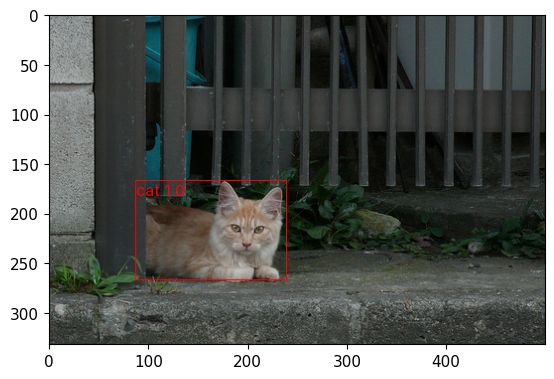

In [ ]:
# Визуализируем предсказание модели на выбранном изображении
img_name = os.listdir("./y_data/images/val/")[42]

# Определяем индекс нашего изображения в списке прогнозов модели
ind = ind_img.index(img_name.split('.')[0])

# Задаем путь к изображению из тестовой выборки
img_path = f'./y_data/images/val/{ind_img[ind]}.jpg'

# подготавливаем изображение
image=Image.open(img_path)

# Создаем объект Draw из нашего изображения для отображения на нем 
# ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
plotted_image = ImageDraw.Draw(image)

# получаем координаты для всех ограничительных рамок текущего изображения
bbox = f_rcnn_preds_filtred[ind]['boxes'].clone().cpu().numpy()

# В цикле перебираем все аннотации
for i, box in enumerate(bbox):
    
    # Получаем параметры текущей аннотации
    x0, y0, x1, y1 = box
       
    # Отрисовываем на объекте Draw ограничительную рамку
    plotted_image.rectangle(((int(box[0]),int(box[1])), (int(box[2]),int(box[3]))),
                    
                   outline="red"
           
                    )
    
    # Добавляем метку класса и уверенность модели в этой метке
    lbl = labels_dict[f_rcnn_preds_filtred[ind]["labels"][i].item()]
    scr = str(round(f_rcnn_preds_filtred[ind]['scores'][i].item(), 2))
    plotted_image.text(xy=(x0, y0), # координаты метки 
                        text=lbl + ' ' + scr, # метка класса и уверенность моели
                        fill='red',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )

# Преобразовываем массив в изображение и выводим его на экран
plt.imshow(np.array(image))
plt.show()  

# Закрываем окно с графиком, а также освобождаем ресурсы памяти
plt.close()


In [ ]:
# Сформируем словарь с результатами
result_dict = {'model': ['fasterrcnn_resnet50_fpn'],
               'parameters': [41755286],
               'GFLOPs': [134.38],
               'train_time': np.sum(epoch_time),
               'time_per_epoch': [int(np.mean(epoch_time))],
               'mAP_50': [0.73642],
               'mAP_50_95': [0.45182]
               }

# Преобразуем его в датафрейм и отобразим результат
df = pd.DataFrame(data=result_dict)
display(df)

# Дозапишем результат в файл
df.to_csv('results_df.csv', index=False, header=False, mode='a')


model  parameters  GFLOPs    train_time  time_per_epoch  \
0  fasterrcnn_resnet50_fpn    41755286  134.38  20297.379332             405   

    mAP_50  mAP_50_95  
0  0.73642    0.45182

In [ ]:
# Выведем результаты для сравнения
df = pd.read_csv('results_df.csv')
display(df)

model  parameters  GFLOPs  train_time, s  \
0                 YOLO v5m    20929713   48.10    2129.473702   
1  fasterrcnn_resnet50_fpn    41755286  134.38   20297.379332   

   time_per_epoch, s   mAP_50  mAP_50_95  
0                 43  0.71000    0.51100  
1                405  0.73642    0.45182

In [ ]:
op

NameError: name 'stop' is not defined

# YOLO v5x6 + TTA

YOLO позволяет использовать Test Time Augmentation (TTA) во время тестирования и вывода для улучшения mAP. Попробуем использовать более тяжелую модель и улучшить результат.

In [29]:
# При обучении увеличим размер изображений до 832, используем гиперпараметры
# из репозитария yolov5/data/hyps/hyp.VOC.yaml, установим размер батча на 8 чтобы хватило 
# памяти используемой GPU (RTX 2080Ti), а также заморозим начальные слои модели.
# Фиксируем время начала и окончания обучения

start = time()
!python yolov5/train.py --batch 8 --weights yolov5x6.pt --data y_data.yaml --epochs 50 --cache --img 832 --hyp hyp.VOC.yaml --freeze 10
stop = time()

train: weights=yolov5x6.pt, cfg=, data=y_data.yaml, hyp=hyp.VOC.yaml, epochs=50, batch_size=8, imgsz=832, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)

hyperparameters: lr0=0.00334, lrf=0.15135, momentum=0.74832, weight_decay=0.00025, warmup_epochs=3.3835, warmup_momentum=0.59462, warmup_bias_lr=0.18657, bo

### Тестирование с TTA
TTA — test-time augmentation — аугментация во время теста. Это способ увеличить качество классификатора за счёт усреднения предсказаний для изображений и их аугментаций. Для включения режим при запуске val.py необходимо добавить ключ --augment.

In [30]:
# Запустим валидацию модели передав ключ --augment
!python yolov5/val.py --weights yolov5/runs/train/exp2/weights/best.pt --data y_data.yaml --img 832 --augment --half

val: data=y_data.yaml, weights=['yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=832, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)

Fusing layers... 
Model summary: 416 layers, 140153500 parameters, 0 gradients, 208.3 GFLOPs
val: Scanning /home/tio/CV/CV_git/homework/m10_HM3/y_data/labels/val.cache... 70
                 Class     Images  Instances          P          R      mAP50   
                   all        701       1531       0.79      0.813      0.862      0.706
             aeroplane        701         41      0.889      0.951      0.961      0.836
               bicycle        701         31      0.745      0.903      0.911      0.777
      

In [36]:
# Выберем изображение для визуализации
img_name = os.listdir("./y_data/images/val/")[42]

# Зададим путь к изображению из валидационной выборки
img_path = 'y_data/images/val/' + img_name

# Визуализируем результат работы нашей модели на выбранном изображении
!python yolov5/detect.py --weights yolov5/runs/train/exp2/weights/best.pt --img 832 --source img_path --augment

detect: weights=['yolov5/runs/train/exp2/weights/best.pt'], source=img_path, data=yolov5/data/coco128.yaml, imgsz=[832, 832], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)

Fusing layers... 
Model summary: 416 layers, 140153500 parameters, 0 gradients, 208.3 GFLOPs
Traceback (most recent call last):
  File "yolov5/detect.py", line 438, in <module>
    main(opt)
  File "yolov5/detect.py", line 433, in main
    run(**vars(opt))
  File "/home/tio/CV/CV_git/homework/m10_HM3/env/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 116, in d

In [ ]:
/home/tio/CV/CV_git/homework/m10_HM3/y_data/images/val/2010_005886.jpg

In [33]:
img_path

'./y_data/images/val/2010_005886.jpg'

In [37]:
# Сформируем словарь с результатами
result_dict = {'model': ['YOLO v5x6 + TTA'],
               'parameters': [140153500],
               'GFLOPs': [208.3],
               'train_time': [stop - start],
               'time_per_epoch': [round((stop - start) / 50)],
               'mAP_50': [0.862],
               'mAP_50_95': [0.706]
               }

# Преобразуем его в датафрейм и отобразим результат
df = pd.DataFrame(data=result_dict)
display(df)

# Дозапишем результат в файл
df.to_csv('results_df.csv', index=False, header=False, mode='a')


model  parameters  GFLOPs   train_time  time_per_epoch  mAP_50  \
0  YOLO v5x6 + TTA   140153500   208.3  6453.265963             129   0.862   

   mAP_50_95  
0      0.706

In [38]:
# Выведем результаты для сравнения
df = pd.read_csv('results_df.csv')
display(df)

model  parameters  GFLOPs  train_time, s  \
0                 YOLO v5m    20929713   48.10    2129.473702   
1  fasterrcnn_resnet50_fpn    41755286  134.38   20297.379332   
2          YOLO v5x6 + TTA   140153500  208.30    6453.265963   

   time_per_epoch, s   mAP_50  mAP_50_95  
0                 43  0.71000    0.51100  
1                405  0.73642    0.45182  
2                129  0.86200    0.70600